In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('data/sales.xlsx', index_col=0)

In [4]:
df.head()

,sales_A,sales_B
day,,
1,28252,15266
2,19669,8991
3,9639,8252
4,7102,13554
5,12865,4283


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 1 to 45
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sales_A  45 non-null     int64
 1   sales_B  45 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB


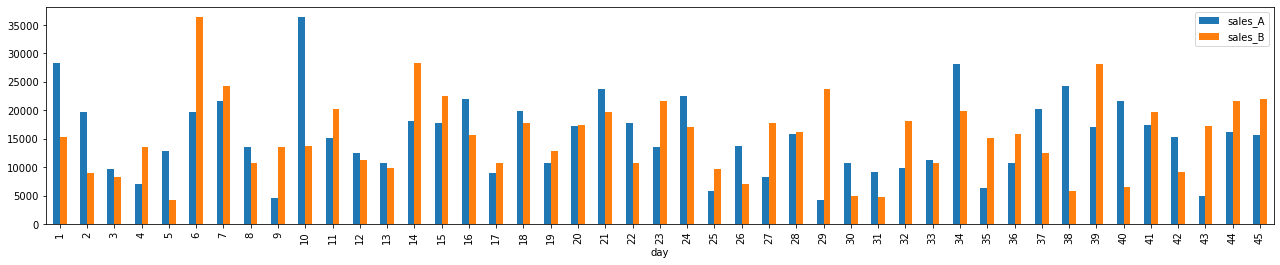

In [5]:
df.plot.bar(figsize = (22,4));

<AxesSubplot:xlabel='day'>

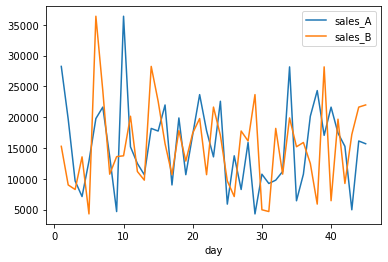

In [15]:
df.plot();

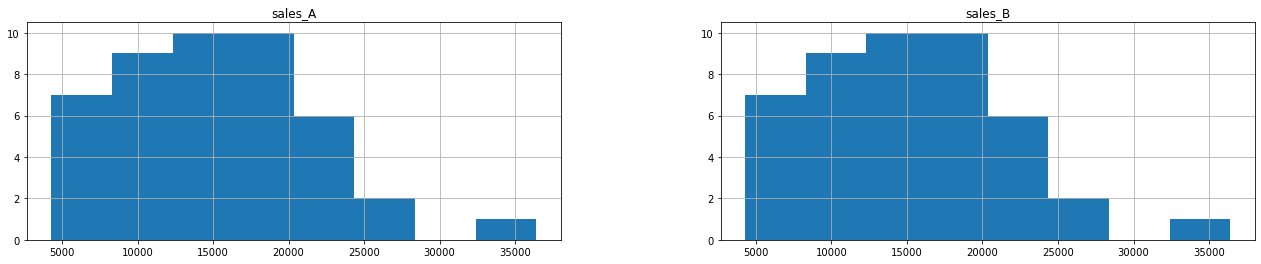

In [16]:
df.hist(bins=8,figsize = (22,4));

The first step is recognixing what sort of distribution to fit our data to. A couple of observations:

-The data are skewed, with a longer tail to the right than to the left

-The data are positive-valued, since they are measuring rainfall

-The data are continuous

In [55]:
df_mean1 = df.mean(axis = 0)
df_mean2 = df.sales_A.mean()
df_mean3 = df.sales_B.mean()

print(df_mean1, df_mean2, df_mean3
    )

sales_A    15357.155556
sales_B    15360.155556
dtype: float64 15357.155555555555 15360.155555555555


In [66]:
df_var = np.var(df)
df_var1 = df.var(axis = 0, ddof=0)
print(df_var,'\n', df_var1)

sales_A    4.698664e+07
sales_B    4.698731e+07
dtype: float64 
 sales_A    4.698664e+07
sales_B    4.698731e+07
dtype: float64


We then use these moments to estimate alfa  and beta for each design(A, B):

In [70]:
alpha = df_mean ** 2 / df_var
alpha1 = df_mean[0]**2/df_var[0]
beta = df_var / df_mean
beta1 = df_var[0] / df_mean[0]
print(alpha, alpha1,'\n', beta, beta1)

sales_A    5.019347
sales_B    5.021236
dtype: float64 5.019347007155889 
 sales_A    3059.592320
sales_B    3059.038705
dtype: float64 3059.592320208476


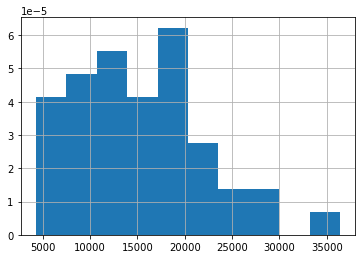

In [89]:
from scipy.stats.distributions import gamma

df.sales_A.hist(density=True);

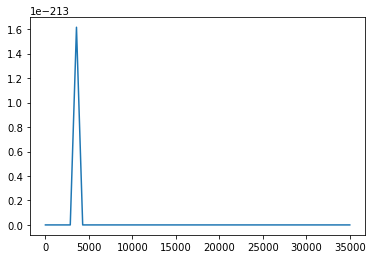

In [90]:
plt.plot(np.linspace(0, 35000), gamma.pdf(np.linspace(0, 35000), alpha[0], beta[0]));

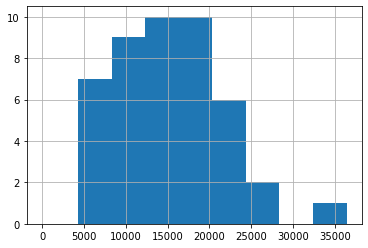

In [83]:
from scipy.stats.distributions import gamma

df.sales_B.hist(bins=8)
plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha[1], beta[1]))

In [14]:
df.std()

sales_A    6932.136270
sales_B    6932.186074
dtype: float64

In [18]:
df.var()

sales_A    4.805451e+07
sales_B    4.805520e+07
dtype: float64